# Carga de Librerías

In [1]:
import sys  
sys.path.insert(0, "C:\\PdM\\utils")
from utils_models import window_size

import math
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
seed(10)

from keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

from pickle import dump

import warnings
warnings.filterwarnings('ignore')

# Introducción

Este notebook realizará el modelo de detección de anomalías a través de un algortimo AutoEncoder LSTM

# Carga del juego de Datos

xxx


In [2]:
# Carga de los datos de la máquina escogida
path_file='C:\PdM\datasets\AE_working_dataset_Autoeconder\PdM_dataset_machine_48_model4_age_10_failure_comp1_serie_2_mod.csv'
df = pd.read_csv(path_file).set_index("datetime")

# Selección de los sensores existentes
df = df[["volt", "rotate", "pressure", "vibration"]]
df

volt      rotate    pressure  vibration
datetime                                                     
4/4/2015 4:00   179.064383  482.787831   82.451540  39.381235
4/4/2015 5:00   158.980293  407.362465   98.743396  41.156902
4/4/2015 6:00   146.094688  535.813136   97.479200  46.864046
4/4/2015 7:00   148.353919  397.618668   93.484187  39.198417
4/4/2015 8:00   166.029908  455.702480  104.514923  43.499835
...                    ...         ...         ...        ...
7/25/2015 2:00  181.691632  415.119099   99.327292  45.108903
7/25/2015 3:00  174.482155  401.766163   84.062437  34.659098
7/25/2015 4:00  187.348433  479.714394   81.386340  34.013300
7/25/2015 5:00  182.224092  395.025863   99.272211  36.598549
7/25/2015 6:00  181.032800  484.957152  104.547808  43.291950

[2691 rows x 4 columns]

# Definición de los conjuntos de Entrenamiento y Test del modelo

Previo a la definición del modelo, se definen los conjuntos de entrenamiento y test.

Debido a que nuestro modelo quiere encontrar anomalías en series temporales, deberemos asumir que en las etapas iniciales de los datos, éstos **no son anómalos**, es decir, representan la operatividad normal de las máquinas (los sensores aportaría datos normales en producción).

Exploraremos la hipótesis que un cierto porcentaje de los datos a utilizar no son anómalos y los declararemos como el conjunto de entrenamiento.

Tomaremos una cierta ventana temporal, que nos definirá la cantidad de ciclos previos que tendremos en cuenta en el modelo autoencoder LSTM.

In [3]:
# Porcentaje de datos "normales" -> 10 
factor = 0.1

# Definición del límite en el juego de datos que separará los valores de entrenamiento de los de test
index_border = math.floor(df.shape[0]*factor)

# Definición de la ventana temporal
size_window = window_size()

# Definción de conjuntos de entrenamiento y test
train = df[0:index_border]
test = df[index_border + 1 - size_window:]

print(f"Hipótesis de porcentaje (%) de datos normales sobre el total: {int(factor*100)} %")

print(f"Ventana temporal de {str(size_window)} ciclos")

print(f"Dimensiones del juego de datos de entrenamiento: {train.shape[0]} filas y {train.shape[1]} columnas.")
print(f"Dimensiones del juego de datos de test: {test.shape[0]} filas y {test.shape[1]} columnas.")


Hipótesis de porcentaje (%) de datos normales sobre el total: 10 %
Ventana temporal de 60 ciclos
Dimensiones del juego de datos de entrenamiento: 269 filas y 4 columnas.
Dimensiones del juego de datos de test: 2481 filas y 4 columnas.


Para poder usar los datos en nuestro modelo AutoEncoder LSTM, primero debemos normalizarlos.
Guardamos en disco en formato pickle (extensión .pkl) la normalización que deberemos cargar de nuevo si deseamos utilizar el modelo en predicciones con valores de la telemetría reales.

In [4]:
# Normalización de los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

# Guardamos en disco la normalización empleada
dump(scaler, open('C:/PdM/datasets/AE_working_dataset_Autoeconder/AE_scaler_M48_S2.pkl', 'wb'))


Debido a la naturaleza de nuestro modelo donde usamos un autoencoder basado en una red neuronal LSTM, la validación de los datos **deberán ser los mismos datos de entrada**.

La idea es obtener un error de similitud generado por el autoencoder y discernir su umbral con el cual definiremos si los datos son anómalos o no.

**Generación del conjunto de validación para los datos de entrenamiento**

In [5]:
# Definición variable
data_train = X_train

# Obtención de la dimensión del juego de entrenamiento
_l = len(data_train) 

# Creación de listas con los datos de cada ventana temporal relativa a su posición
# Debido a que el modelo es un AutoEncoder, las Xtn y las Ytn deben ser las mismas, sin tener ningún decalaje temporal

Xtn = []
Ytn = []

for i in range(0, (_l - size_window + 1)):
    Xtn.append(data_train[i:(i + size_window)])
    Ytn.append(data_train[i:(i + size_window)])

# Redimensionamiento numpy arrays para obtener las dimensiones de ingesta correctas en un modelo LSTM

Xtn_np = np.array(Xtn)
Xtn_np = np.reshape(Xtn_np, (Xtn_np.shape[0], Xtn_np.shape[1], train.shape[1]))

Ytn_np = np.array(Ytn)
Ytn_np = np.reshape(Ytn_np, (Ytn_np.shape[0], Ytn_np.shape[1], train.shape[1]))

**Generación del conjunto de validación para los datos de test**

In [6]:
# Definición variable
data_test = X_test

# Obtención de la dimensión del juego de test
_lt = len(data_test) 

# Creación de listas con los datos de cada ventana temporal relativa a su posición
# Debido a que el modelo es un AutoEncoder, las Xtn y las Ytn deben ser las mismas, sin tener ningún decalaje temporal

Xt = []
Yt = []

for i in range(0, (_lt - size_window + 1)):
    Xt.append(data_test[i:(i + size_window)])
    Yt.append(data_test[i:(i + size_window)])

# Redimensionamiento numpy arrays para obtener las dimensiones de ingesta correctas en un modelo LSTM

Xt_np = np.array(Xt)
Xt_np = np.reshape(Xt_np, (Xt_np.shape[0], Xt_np.shape[1], test.shape[1]))

Yt_np = np.array(Yt)
Yt_np = np.reshape(Yt_np, (Yt_np.shape[0], Yt_np.shape[1], test.shape[1]))

Renombramos las variables para una mejor comprensión.

In [7]:
# Renombramiento variables

X_train = Xtn_np
Y_train = Ytn_np
print(f"Dimenciones del conjunto de entrenamiento: {X_train.shape}")


X_test = Xt_np 
Y_test = Yt_np
print(f"Dimenciones del conjunto de test: {X_test.shape}")

Dimenciones del conjunto de entrenamiento: (210, 60, 4)
Dimenciones del conjunto de test: (2422, 60, 4)


# Definición y generación del modelo AutoEncoder - LSTM

In [8]:
# Definición del modelo Autoencoder - LSTM

def autoencoder_model(X):
    """ Definición modelo AutoEnconder - LSTM"""

    # Encoder
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    
    # Espacio Latente
    L3 = RepeatVector(X.shape[1])(L2)

    # Decoder
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    
    # Definición modelo AE - LSTM
    model = Model(inputs=inputs, outputs=output)
    return model

In [9]:
# Creación y compilado del modelo
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 4)]           0         
                                                                 
 lstm (LSTM)                 (None, 60, 16)            1344      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 60, 4)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 60, 4)             144       
                                                                 
 lstm_3 (LSTM)               (None, 60, 16)            1344      
                                                             

In [10]:
# Entrenamiento del modelo
nb_epochs = 5
batch_size = 10
history = model.fit(X_train,
                    Y_train, 
                    epochs=nb_epochs, 
                    batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/5
20/20 [==============================] - 9s 125ms/step - loss: 0.3849 - val_loss: 0.3234
Epoch 2/5
20/20 [==============================] - 1s 73ms/step - loss: 0.2838 - val_loss: 0.2502
Epoch 3/5
20/20 [==============================] - 1s 73ms/step - loss: 0.2349 - val_loss: 0.2157
Epoch 4/5
20/20 [==============================] - 1s 72ms/step - loss: 0.2072 - val_loss: 0.1940
Epoch 5/5
20/20 [==============================] - 2s 83ms/step - loss: 0.1844 - val_loss: 0.1777


In [11]:
# Visualización del coste de la métrica (entrenamiento y validación)

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (MAE)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribuciones de las funciones de coste

Una vez calculado el modelo, y visualizando las distribuciones de los errores entre los conjuntos de entrenamiento y su predicción, podremos intuir y definir un valor del umbrar para poder identificar potenciales anomalías.

Fijando un umbral adecuado, evitaremos interferencias de los datos (ruido) y nos aseguraremos que las anomalías son estadísticamente significativas.

Para poder perfilar mejor el modelo, **se decide definir cuatro umbrales, uno para cada sensor**, y así ajustar mejor la extracción de posible ruido en la telemetría.

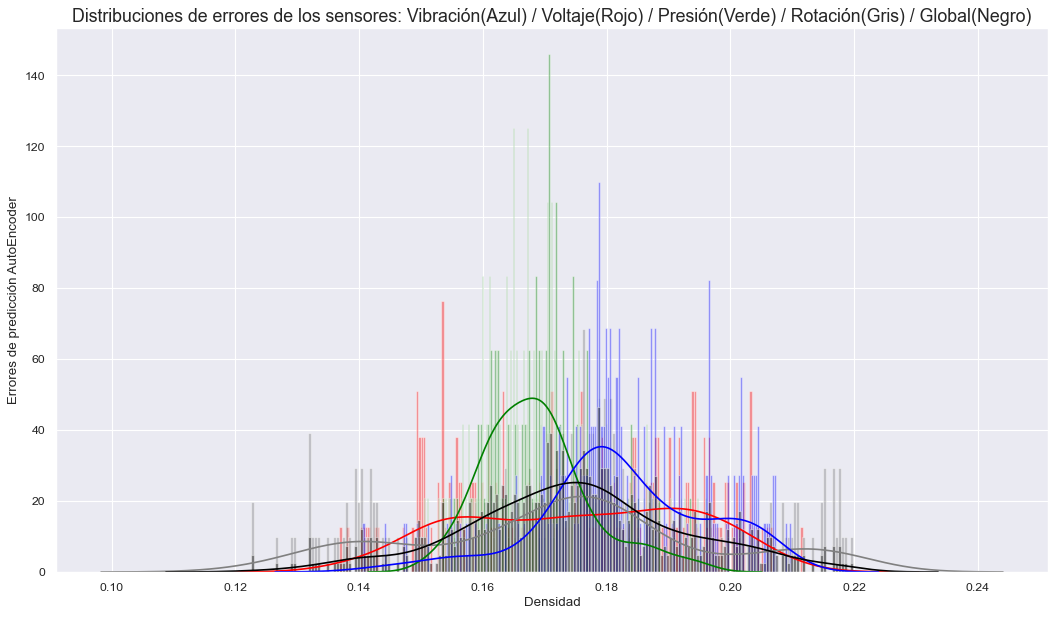

In [12]:
# Cálculo de las predicciones del conjunto de entrenamiento
X_pred = model.predict(X_train)

# Debido a que el modelo es un AutoEncoder, podemos extraer el error sobre la diferencia del propio input con su predicción.
train_loss = np.mean(np.abs(X_pred-Y_train), axis = 1)

# Realizamos el cálculo de la pérdida global a través de su estadístico de la media.
avg_loss_tn = train_loss.mean()

#train_loss = train_loss.reshape(train_loss.shape[0], 4)
df_loss_tn = pd.DataFrame(train_loss, columns=["volt_loss", "rotate_loss", "pressure_loss", "vibration_loss"])

plt.figure(figsize=(16,9), dpi=80)
plt.title('Distribuciones de errores de los sensores: Vibración(Azul) / Voltaje(Rojo) / Presión(Verde) / Rotación(Gris) / Global(Negro)', fontsize=16)
sns.distplot(df_loss_tn["volt_loss"], bins = 200, kde= True, color = 'red')
sns.distplot(df_loss_tn["rotate_loss"], bins = 200, kde= True, color = 'grey')
sns.distplot(df_loss_tn["pressure_loss"], bins = 200, kde= True, color = 'green')
sns.distplot(df_loss_tn["vibration_loss"], bins = 200, kde= True, color = 'blue')
sns.distplot(df_loss_tn, bins = 200, kde= True, color = 'black')

plt.xlabel("Densidad")
plt.ylabel("Errores de predicción AutoEncoder")
#plt.xlim([0.02,.25])

plt.show()



Observando las distribuciones, se fijan como umbrales los siguientes valores:

In [13]:
# Vibración -> Azul
AE_threshold_vibration = 0.21

# Voltaje -> Rojo
AE_threshold_volt = 0.121

# Presión -> Verde
AE_threshold_pressure = 0.2

# Rotación -> Gris
AE_threshold_rotate = 0.22

# Definición de umbrales 

In [14]:
def anomaly(serie):
    """Modifica los datos de una seria de booleanos a 0 si el dato es falso y 1 si es verdadero"""
    for indice_booleano,booleano in enumerate(serie):
        if booleano == False:
            serie[indice_booleano] = 0
        else:
            serie[indice_booleano] = 1
    return serie

df_loss_tn['Threshold_volt'] = AE_threshold_volt
df_loss_tn['Anomaly_volt'] = anomaly(df_loss_tn['volt_loss'] > df_loss_tn['Threshold_volt'])

df_loss_tn['Threshold_rotate'] = AE_threshold_rotate
df_loss_tn['Anomaly_rotate'] = anomaly(df_loss_tn['rotate_loss'] > df_loss_tn['Threshold_rotate'])

df_loss_tn['Threshold_pressure'] = AE_threshold_pressure
df_loss_tn['Anomaly_pressure'] = anomaly(df_loss_tn['pressure_loss'] > df_loss_tn['Threshold_pressure'])

df_loss_tn['Threshold_vibration'] = AE_threshold_vibration
df_loss_tn['Anomaly_vibration'] = anomaly(df_loss_tn['vibration_loss'] > df_loss_tn['Threshold_vibration'])

print(f"Dimensiones del dataframe: {df_loss_tn.shape[0]} filas y {df_loss_tn.shape[1]} columnas")
print(f"Error medio obtenido (MAE): {avg_loss_tn}")
df_loss_tn.tail()


Dimensiones del dataframe: 210 filas y 12 columnas
Error medio obtenido (MAE): 0.17486642546072875


volt_loss  rotate_loss  pressure_loss  vibration_loss  Threshold_volt  \
205   0.159137     0.178756       0.170267        0.201926           0.121   
206   0.159786     0.180280       0.170212        0.201667           0.121   
207   0.154628     0.181315       0.175926        0.197017           0.121   
208   0.149249     0.180617       0.178828        0.196522           0.121   
209   0.142711     0.183966       0.173641        0.186287           0.121   

    Anomaly_volt  Threshold_rotate Anomaly_rotate  Threshold_pressure  \
205            1              0.22              0                 0.2   
206            1              0.22              0                 0.2   
207            1              0.22              0                 0.2   
208            1              0.22              0                 0.2   
209            1              0.22              0                 0.2   

    Anomaly_pressure  Threshold_vibration Anomaly_vibration  
205                0                 0.21                 0  
206                0                 0.21                 0  
207                0                 0.21                 0  
208                0                 0.21                 0  
209                0                 0.21                 0

De igual forma, calcularemos los errores en en conjunto de test usando los mismos umbrales de error declarados en el conjunto de entrenamiento

In [15]:
# Cálculo de errores en el conjunto de test
X_pred_t = model.predict(X_test)
test_loss = np.mean(np.abs(X_pred_t-Y_test), axis = 1)
avg_loss_t = test_loss.mean()


df_loss_t = pd.DataFrame(test_loss, columns=["volt_loss", "rotate_loss", "pressure_loss", "vibration_loss"])


df_loss_t['Threshold_volt'] = AE_threshold_volt
df_loss_t['Anomaly_volt'] = anomaly(df_loss_t['volt_loss'] > df_loss_t['Threshold_volt'])

df_loss_t['Threshold_rotate'] = AE_threshold_rotate
df_loss_t['Anomaly_rotate'] = anomaly(df_loss_t['rotate_loss'] > df_loss_t['Threshold_rotate'])

df_loss_t['Threshold_pressure'] = AE_threshold_pressure
df_loss_t['Anomaly_pressure'] = anomaly(df_loss_t['pressure_loss'] > df_loss_t['Threshold_pressure'])

df_loss_t['Threshold_vibration'] = AE_threshold_vibration
df_loss_t['Anomaly_vibration'] = anomaly(df_loss_t['vibration_loss'] > df_loss_t['Threshold_vibration'])

print(f"Dimensiones del dataframe: {df_loss_t.shape[0]} filas y {df_loss_t.shape[1]} columnas")
print(f"Error medio obtenido (MAE): {avg_loss_t}")
df_loss_t.tail()

Dimensiones del dataframe: 2422 filas y 12 columnas
Error medio obtenido (MAE): 0.298292266679908


volt_loss  rotate_loss  pressure_loss  vibration_loss  Threshold_volt  \
2417   0.173969     0.163105       0.172408        0.254929           0.121   
2418   0.177211     0.164227       0.177899        0.259671           0.121   
2419   0.156782     0.159949       0.175632        0.230015           0.121   
2420   0.159726     0.159057       0.164586        0.212639           0.121   
2421   0.166012     0.154973       0.160133        0.208053           0.121   

     Anomaly_volt  Threshold_rotate Anomaly_rotate  Threshold_pressure  \
2417            1              0.22              0                 0.2   
2418            1              0.22              0                 0.2   
2419            1              0.22              0                 0.2   
2420            1              0.22              0                 0.2   
2421            1              0.22              0                 0.2   

     Anomaly_pressure  Threshold_vibration Anomaly_vibration  
2417                0                 0.21                 1  
2418                0                 0.21                 1  
2419                0                 0.21                 1  
2420                0                 0.21                 1  
2421                0                 0.21                 0

In [16]:
# Concatenación del conjunto de datos de entrenamiento y test
df_loss_all = pd.concat([df_loss_tn, df_loss_t])
df_loss_all = df_loss_all.reset_index()

df_loss_all

index  volt_loss  rotate_loss  pressure_loss  vibration_loss  \
0         0   0.179917     0.173130       0.161189        0.169995   
1         1   0.175861     0.168374       0.170362        0.169879   
2         2   0.171272     0.171050       0.169868        0.173473   
3         3   0.170832     0.169248       0.170666        0.170920   
4         4   0.171811     0.174209       0.171897        0.173691   
...     ...        ...          ...            ...             ...   
2627   2417   0.173969     0.163105       0.172408        0.254929   
2628   2418   0.177211     0.164227       0.177899        0.259671   
2629   2419   0.156782     0.159949       0.175632        0.230015   
2630   2420   0.159726     0.159057       0.164586        0.212639   
2631   2421   0.166012     0.154973       0.160133        0.208053   

      Threshold_volt Anomaly_volt  Threshold_rotate Anomaly_rotate  \
0              0.121            1              0.22              0   
1              0.121            1              0.22              0   
2              0.121            1              0.22              0   
3              0.121            1              0.22              0   
4              0.121            1              0.22              0   
...              ...          ...               ...            ...   
2627           0.121            1              0.22              0   
2628           0.121            1              0.22              0   
2629           0.121            1              0.22              0   
2630           0.121            1              0.22              0   
2631           0.121            1              0.22              0   

      Threshold_pressure Anomaly_pressure  Threshold_vibration  \
0                    0.2                0                 0.21   
1                    0.2                0                 0.21   
2                    0.2                0                 0.21   
3                    0.2                0                 0.21   
4                    0.2                0                 0.21   
...                  ...              ...                  ...   
2627                 0.2                0                 0.21   
2628                 0.2                0                 0.21   
2629                 0.2                0                 0.21   
2630                 0.2                0                 0.21   
2631                 0.2                0                 0.21   

     Anomaly_vibration  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
2627                 1  
2628                 1  
2629                 1  
2630                 1  
2631                 0  

[2632 rows x 13 columns]

Visualizamos los umbrales relativos en la totalidad del conjunto de datos.

Observamos que la declaración de anomalía concuerda con valores que sobrepasan los umbrales designados y concuerdan bastante bien con el gráfico generado durante la EDA.


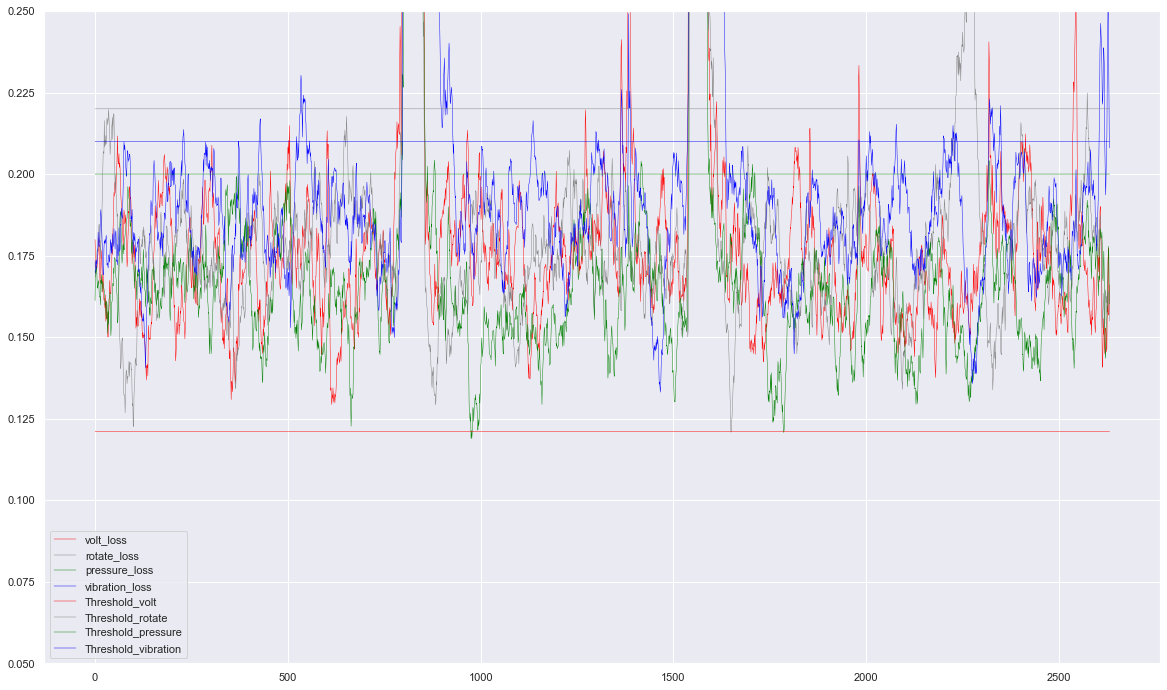

In [17]:
# Visualización umbrales versus telemetria
df_loss_plot = df_loss_all[["volt_loss", "rotate_loss", "pressure_loss", "vibration_loss", "Threshold_volt", "Threshold_rotate","Threshold_pressure","Threshold_vibration"]]
df_loss_plot.plot(logy=False,  figsize=(20,12), ylim=[0.05,0.25], linewidth=0.45, color=['red','grey', "green", "blue"])
plt.show()

In [18]:
# Borramos las columnas de los umbrales
df_loss_all= df_loss_all.drop('Threshold_volt', 1)
df_loss_all= df_loss_all.drop('Threshold_rotate', 1)
df_loss_all= df_loss_all.drop('Threshold_pressure', 1)
df_loss_all= df_loss_all.drop('Threshold_vibration', 1)
df_loss_all

index  volt_loss  rotate_loss  pressure_loss  vibration_loss  \
0         0   0.179917     0.173130       0.161189        0.169995   
1         1   0.175861     0.168374       0.170362        0.169879   
2         2   0.171272     0.171050       0.169868        0.173473   
3         3   0.170832     0.169248       0.170666        0.170920   
4         4   0.171811     0.174209       0.171897        0.173691   
...     ...        ...          ...            ...             ...   
2627   2417   0.173969     0.163105       0.172408        0.254929   
2628   2418   0.177211     0.164227       0.177899        0.259671   
2629   2419   0.156782     0.159949       0.175632        0.230015   
2630   2420   0.159726     0.159057       0.164586        0.212639   
2631   2421   0.166012     0.154973       0.160133        0.208053   

     Anomaly_volt Anomaly_rotate Anomaly_pressure Anomaly_vibration  
0               1              0                0                 0  
1               1              0                0                 0  
2               1              0                0                 0  
3               1              0                0                 0  
4               1              0                0                 0  
...           ...            ...              ...               ...  
2627            1              0                0                 1  
2628            1              0                0                 1  
2629            1              0                0                 1  
2630            1              0                0                 1  
2631            1              0                0                 0  

[2632 rows x 9 columns]

In [19]:
# Añadimos los resultados del modelo sobre las anomalías 
df['Anomaly_volt'] = df['Anomaly_rotate'] = df['Anomaly_pressure'] = df['Anomaly_vibration'] = [None]*df.shape[0]

df['Anomaly_volt'][-df_loss_all.shape[0]:] =  df_loss_all["Anomaly_volt"]
df['Anomaly_rotate'][-df_loss_all.shape[0]:] =  df_loss_all["Anomaly_rotate"]
df['Anomaly_pressure'][-df_loss_all.shape[0]:] =  df_loss_all["Anomaly_pressure"]
df['Anomaly_vibration'][-df_loss_all.shape[0]:] =  df_loss_all["Anomaly_vibration"]


df.tail()

volt      rotate    pressure  vibration Anomaly_volt  \
datetime                                                                     
7/25/2015 2:00  181.691632  415.119099   99.327292  45.108903            1   
7/25/2015 3:00  174.482155  401.766163   84.062437  34.659098            1   
7/25/2015 4:00  187.348433  479.714394   81.386340  34.013300            1   
7/25/2015 5:00  182.224092  395.025863   99.272211  36.598549            1   
7/25/2015 6:00  181.032800  484.957152  104.547808  43.291950            1   

               Anomaly_rotate Anomaly_pressure Anomaly_vibration  
datetime                                                          
7/25/2015 2:00              0                0                 1  
7/25/2015 3:00              0                0                 1  
7/25/2015 4:00              0                0                 1  
7/25/2015 5:00              0                0                 1  
7/25/2015 6:00              0                0                 0

# Creación del archivo base para el modelo LSTM

In [20]:
df.to_csv('C:/PdM//datasets/AE_working_dataset_Autoeconder/autoencoder_M48_S2.csv')  

# Creación del archivo con el modelo

In [21]:
# Guardamos toda la información del archivo en formato HDF
model.save("C:/PdM/models/model_Autoencoder_M48_S2.h5")